# Data preporcesssing

In [1]:
#libraties
import pandas as pd
import re, nltk, spacy, string, stanza
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
import spacy.cli
import numpy as np

#spacy.cli.download("en_core_web_md")
#nltk.download('wordnet')
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

#from custom_functions import *

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

D:\Download\KUL\Statisticalsoftware\tools\Anaconda\Anaconda\lib\site-packages\sklearn\decomposition\_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [2]:
#improt dataset
df = pd.read_csv('D:/Download/KUL/2nd semester/Modern Data Analysis/project/consolidated-transcripts.csv',delimiter=',')

In [3]:
stopwords = ['united','nations','nation', 'international','society','organization','organizations','member','state',
                                'relations','relation','global','charter','general','assembly','year','ago','/n','/t','/n/n']

In [4]:
#date cleaning
class DataCleaners():

    def clean_text(text):
        text = text.lower()
        text = re.sub("\n", '', text)
        text = re.sub("\t",'',text)
        text = re.sub(r'[0-9]', '', text) #ideally this removes only line number such as "xxx." 9/11 can be an important nb
        text = re.sub(r'\[,!.*?\]', '', text)
        text = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', text) # removes the possibility to tokenize by sentence
        return text
    
    def remove_stopwords(text,stopwords):
        filtered = []
        stopwords_corpus = nltk.corpus.stopwords.words('english')
        stopwords_additional = stopwords
        stop_words = stopwords_corpus + stopwords_additional
        stemmer = WordNetLemmatizer()
        word_tokens = word_tokenize(text)
        for w in word_tokens:
            if w not in stop_words:
                w = stemmer.lemmatize(w)
                filtered.append(w)
        filtered_doc = ' '.join(str(i) for i in filtered)
        return filtered_doc
    
    def lemmatizer(text):
        nlp = spacy.load('en_core_web_sm')
        sent = []
        doc = nlp(text)
        for word in doc:
            sent.append(word.lemma_)
        return " ".join(sent)

In [5]:
df['Transcript'] = df['Transcript'].apply(lambda x : DataCleaners.clean_text(str(x)))
df['Transcript'] = df['Transcript'].apply(lambda x : DataCleaners.remove_stopwords(str(x),stopwords))

In [8]:
df['Transcript'] = df['Transcript'].apply(lambda x : DataCleaners.lemmatizer(str(x)))

In [9]:
df.to_csv('D:/Download/KUL/2nd semester/Modern Data Analysis/project/transcript_preprocessed_compact_02.csv',encoding='utf-8')

# Topic Modelling

In [ ]:
#improt dataset
df = pd.read_csv('D:/Download/KUL/2nd semester/Modern Data Analysis/project/transcript_preprocessed_compact_02.csv')

In [11]:
df['sentence_lemmatize_clean'] = df['Transcript'].str.replace('-PRON-', '')

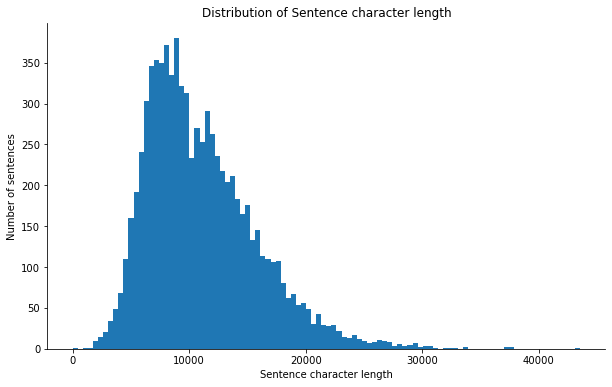

In [12]:
import seaborn as sns

plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df['sentence_lemmatize_clean']]
plt.hist(doc_lens, bins = 100)
plt.title('Distribution of Sentence character length')
plt.ylabel('Number of sentences')
plt.xlabel('Sentence character length')
sns.despine();

In [15]:
def get_top_n_ngram(corpus, n=None,ngram=None):
    vec = CountVectorizer(ngram_range=(ngram, ngram), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [17]:
common_words_bi = get_top_n_ngram(df['sentence_lemmatize_clean'], n = 20, ngram = 2)
df_bi = pd.DataFrame(common_words_bi, columns = ['bigram' , 'count'])
df_bi

,bigram,count
0,develop country,23928
1,human right,19300
2,security council,18813
3,peace security,14934
4,middle east,11773
5,south africa,10908
6,nuclear weapon,8110
7,economic social,7093
8,climate change,6703
9,sustainable development,6230


In [ ]:
fig = go.Figure([go.Bar(x=df_bi['bigram'], y=df_bi['count'])])
fig.update_layout(title=go.layout.Title(text="Top 20 bigrams in the question text after removing stop words and lemmatization"))
fig.show()

In [19]:
common_words_tri = get_top_n_ngram(df['sentence_lemmatize_clean'], n = 20, ngram = 3)
df_tri = pd.DataFrame(common_words_tri, columns = ['trigram' , 'count'])
df_tri

,trigram,count
0,security council resolution,4390
1,right self determination,2347
2,new economic order,2296
3,millennium development goal,2022
4,respect human right,1860
5,weapon mass destruction,1830
6,non align country,1723
7,second world war,1589
8,sovereignty territorial integrity,1505
9,right palestinian people,1483


In [ ]:
fig = go.Figure([go.Bar(x=df_tri['bigram'], y=df_tri['count'])])
fig.update_layout(title=go.layout.Title(text="Top 20 trigrams in the question text after removing stop words and lemmatization"))
fig.show()